# Working with videos and images Part 2

### The linear blending operator

The blending between two images can be achieved by the following linear combination:

$$
\begin{align}
	C= \left(1-\alpha\right) I_1 + \alpha I_2,
	\label{blending}
\end{align}
$$

where $\alpha \in \left[0,1\right]$. For example, for $\alpha=0.5$, the combined image $C$ is a equal mixture of the pixel intensities (or colors) in $I_1$ and $I_2$. As the value of $\alpha$ varies between 0 to 1, the mixture proportions change resulting in a temporal cross-dissolve sequence of images.

We can also use the linear blending operator for combining images weighted by alpha mattes. In this case, the $\alpha$ parameter becomes a map of the same dimension of the dimension of the input images.

The alpha matte map is a scalar map. Each value will be used as a weight of a pixel in  weighted-average of the two images. As a result, the multiplication of the alpha matte by the images needs to be an element-wise multiplication instead of a matrix multiplication. Figure 2 illustrate the blending of images B and F to produce image C.

![blending](alpha_blending.png)
**Figure 1**: Blending equation shown in matrices (Figure from Szeliski's Book: http://szeliski.org/Book/).


### Sigmoid function as an alpha matte


Sometimes we create the alpha matte synthetically by using functions. For example, the alpha matte in the figure below defines a vertical blending boundary:

![alpha_matte](./burt_matte.png)

**Figure 2**: Alpha mattes with wide feathering (Figure from: https://cs.brown.edu/courses/csci1290/labs/lab_compositing/index.html).

and is created by calculating a sigmoid function over a rectangular grid of the same dimensions of the images to be blended. The canonical equation of the sigmoid function is given by:  

$$
\begin{align}
	s\left(x,y\right)= \frac{1}{1+e^{-x}}.
	\label{sigmoid}
\end{align}
$$

In this canonical form (i.e., the simplest form), the function's inflexion point is at $x=0$. We need to extend the equation to account for a translation to any column in the image matrix and also to smooth the slope a bit so the inflexion transition is less abrupt.   

### Sigmoid function with scaling and translation

In the case of the alpha matte in Figure 2, we want to use a form of the sigmoid function that allows for translation and scaling (of the slope). In this way, we can translate the function to the point that we want the blending to take place. With the scaling parameter, we can change the slope of the sigmoid for a smooth transition. This variation of the sigmoid is given by:

$$
\begin{align}
	s\left(x,y\right)= \frac{1}{1+e^{-\gamma \left(x-\epsilon\right)}},
	\label{sigmoidext}
\end{align}
$$

where $\gamma$ is the scale factor controling the slope of the transition region and $\epsilon$ is the translation parameter.

### Task 5: Using linear blending

Apply linear blending to blend the images of the apple and orange (or any other images you choose). You can find images and description of the method here: https://cs.brown.edu/courses/csci1290/labs/lab_compositing/index.html

In [3]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

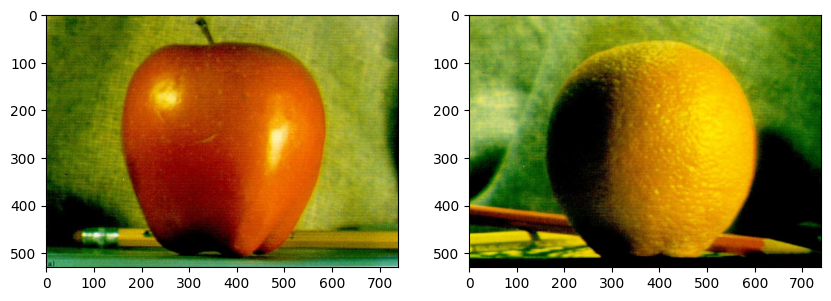

In [4]:
apple = cv2.cvtColor(cv2.imread("./burt_apple.png"), cv2.COLOR_BGR2RGB)
orange = cv2.cvtColor(cv2.imread("./burt_orange.png"), cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(apple)
ax2.imshow(orange)
plt.show()


In [5]:

# Getting image dimensions. They are needed for for creating the alpha matte amp.
height, width, nchannels = apple.shape

print("Height: ", height)
print("Width: ", width)
print("Color: ", nchannels)

Height:  530
Width:  740
Color:  3


In [6]:
def sigmoid_funct(x,y,gamma,epsilon):

    sigExp = gamma * (x - epsilon)
    s = 1 / (1 + np.e ** (-sigExp) )

    return s

In [7]:
X = np.arange(0,width)
Y = np.arange(0,height)
x, y = np.meshgrid( X, Y)

In [8]:
gamma = .1         # slope
epsilon = width/2  # translation
s1 = sigmoid_funct(X,y, 0.100, width/2)   # Domain is X, just the 1-D version of the function
s2 = sigmoid_funct(X,y, 0.015, width/2)   # Domain is X, just the 1-D version of the function
s3 = sigmoid_funct(X,y, 0.010, width/2)   # Domain is X, just the 1-D version of the function

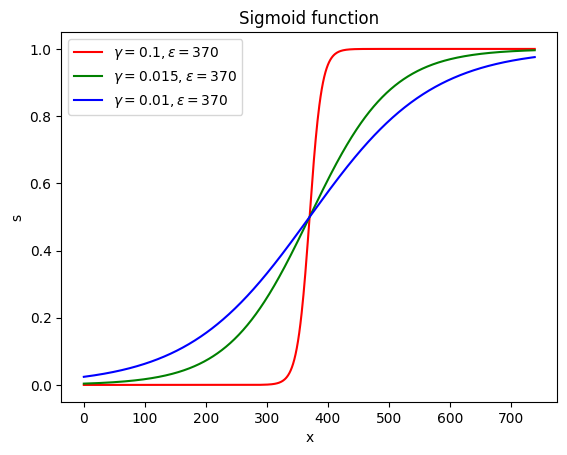

In [9]:
plt.plot(s1, color='r', label='$\gamma =  0.1, \epsilon = 370$')
plt.plot(s2, color='g', label='$\gamma =  0.015, \epsilon = 370$')
plt.plot(s3, color='b', label='$\gamma =  0.01, \epsilon = 370$')
plt.title('Sigmoid function')
plt.xlabel("x")
plt.ylabel("s")
plt.legend()
plt.show()

In [10]:
matte_1 = sigmoid_funct(x,y, 0.100, width/2)

alpha = np.stack((matte_1,matte_1,matte_1), axis=2)

print(np.shape(alpha))

#plt.imshow(matte_1,cmap='gray')
#plt.show()

(530, 740, 3)


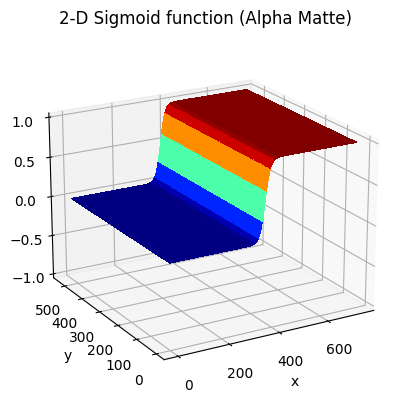

In [11]:
import matplotlib.pyplot as pyplt
import numpy as np
from matplotlib import cm

fig, ax = pyplt.subplots(subplot_kw={"projection": "3d"})


# Plot the surface.
surf = ax.plot_surface(x, y, matte_1, cmap=cm.jet,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=20., azim=-120, roll=0)
ax.set_title('2-D Sigmoid function (Alpha Matte)')

pyplt.show()

In [13]:
def blendtwoimages(im1, im2, alpha):
  blended_img=(1-alpha)*im1+alpha*im2
  return blended_img    # blended image matrix (float64)

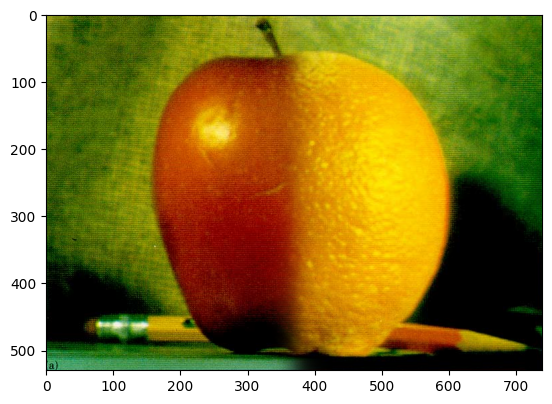

In [14]:
blended_img = blendtwoimages(apple, orange, alpha)

blended_img = blended_img.astype(np.int32)
plt.imshow(blended_img)
plt.show()